# Homework 4 : Model Selection

The goal of this homework is find a suitable model that can distinguish handwritten digits.

In [ ]:
import random
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import sklearn

def prepareData(n=1000):
    """
    Downloads the dataset. Displays some examples.
    Returns the labeled dataset.

    Parameters
    ----------
    n : number of data sample (max 70 000)

    Returns
    -------
    X : Data Matrix
        (n, 28, 28).
    y : labels
        n

    """
    mnist_train = torchvision.datasets.MNIST("./data", download=True,)
    mnist_test = torchvision.datasets.MNIST("./data", download=True, train = False)
    

    
    X = []
    y = []
    for x,label in mnist_train:
        X.append(np.array(x))
        y.append(label)
    
    X_test = []
    y_test = []
    for x,label in mnist_test:
        X_test.append(np.array(x))
        y_test.append(label)
    
    X = np.array(X)
    y = np.array(y)
    X_test= np.array(X_test)
    y_test = np.array(y_test)
    
    
    sample = random.sample(range(len(X)), n)
    X = np.concatenate((X,X_test))[sample]
    y = np.concatenate((y,y_test))[sample]
    
    
    return X,y

def showSamples(X,y):
    fig=plt.figure(figsize=(8, 5))
    columns = 5
    rows = 2
    imgs = [X[i,:,:] for i in range(10)]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(X[i-1,:,:] , cmap ="gray")
        plt.axis('off')
        plt.title(str(y[i-1]))
    plt.show()

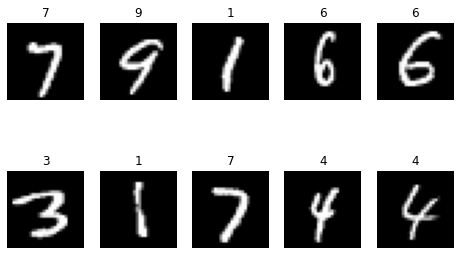

Shape of data matrix X: (1000, 28, 28)
Shape of labels y: (1000,)


In [2]:
X,y = prepareData(1000)
showSamples(X,y)
print("Shape of data matrix X:", X.shape)
print("Shape of labels y:", y.shape)

# Extract features and Train Model

TODO:
- Use any feature extraction method. Compute edges, histogram of oriented gradients, contours etc. to get a more concise representation of the images. 
- Train different models to learn a classification. 
 - You can use any classification model. However, it is easier to use the models from sklearn: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
 

In [3]:
def featureExtraction(x,method):
    """
    Applies a feature extraction on a singular image.

    Parameters
    ----------
    x : ndarray
        a numpy array of shape 28x28

    Returns
    -------
    ndarray
        The resulting feature should be one-dimensional (use x.flatten())
    """
    #TODO: Define a feauture extraction method. 
    # This method is called individually on each data point. 
    # You can also look into methods that do feature extraction on the complete dataset.
    if(method == "pca"):
        from sklearn.decomposition import PCA

        pca = PCA(n_components=20)
        pca.fit(x)

        return pca.singular_values_
    elif(method == "edge"):
        import cv2 
        img_blur = cv2.GaussianBlur(x, (3,3), 0)

        edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
        return edges.flatten()
    elif(method == "nn"):
        return x.flatten()
    
def preprocessDataset(X, method):
    """
    Applies a feature extraction on a dataset

    Parameters
    ----------
    X : ndarray
        Data matrix of size nx28x28
    Returns
    -------
    X_prep : ndarray
        Data matrix of size nxd where d is some dimension of the feature
    """
    
    # TODO: (Optional) You can change this if necessary
    X_prep = []
    for i in range(len(X)):
        x = X[i,:,:]
        x = featureExtraction(x, method)
        X_prep.append(x)    
    X_prep = np.array(X_prep)
    return X_prep


def train(X, y, classfier):
    # TODO: Select a classifier from sklearn and train it on the data
    if(classfier == "bayes"):
        from sklearn.naive_bayes import GaussianNB
        model = GaussianNB()
        model.fit(X, y)
        return model
    elif(classfier == "dtree"):
        from sklearn import tree
        model = tree.DecisionTreeClassifier()
        model = model.fit(X, y)
        return model
    elif(classfier == "mlp"):
        from sklearn.neural_network import MLPClassifier
        model = MLPClassifier(solver='adam', alpha=1e-1,hidden_layer_sizes=(5,5))
        model.fit(X, y)
        return model

# K-fold Cross Validation

TODO:
- Implement K-Fold Cross Validation
 - Split data into k partitions
 - Train model on k-1 partitions
 - Evaluate model on remaining partition using **Accuracy** as a metric
 - repeat k-times and compute **average Accuracy** over all splits
 
The following code computes cross-validation on a single data split.
Adjust the code to evaluate on multiple splits.

In [ ]:
import itertools

# Number of data samples (reduce number during initial test runs if procedure takes too long)
n = 50000
X, y = prepareData(n)

methods = ["pca","edge", "nn"]
classfiers = ["bayes", "dtree", "mlp"]

X_records = {}
y_records = {}

for method, classfier in list(itertools.product(methods, classfiers)):
    # Feature extraction
    D = preprocessDataset(np.copy(X), method)

    # Number of k-folds
    n_splits = 5
    # train_size = len(X) - len(X)//n_splits
    test_size = len(X)//n_splits

    X_record = []
    y_record = []

    for i in range(n_splits):

        # Cross Validation on a single split: First k-1 splits are used for training and remaining for evaluation.
        X_test = np.copy(D[test_size * i:test_size*(i+1)])
        y_test = np.copy(y[test_size * i:test_size*(i+1)])

        if(i == 0):
            X_train = np.copy(D[test_size: ])
            y_train = np.copy(y[test_size:])
        elif(i == n_splits-1):
            X_train = np.copy(D[:test_size*i])
            y_train = np.copy(y[:test_size*i])
        else:
            X_train = np.copy(np.concatenate((D[:test_size],D[test_size*(i+1):])))
            y_train = np.copy(np.concatenate((y[:test_size],y[test_size*(i+1):])))

        # Train model
        model = train(X_train, y_train, classfier)
        

        # Evaluate model on unseen data
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
#         print(method + " " + classfier + ": ", end='')
#         print("Accuracy Training:" + str(accuracy_score(y_train,y_pred_train)) + ", ", end='')
#         print("Accuracy Test:" + str(accuracy_score(y_test,y_pred)))
        X_record.append(accuracy_score(y_train,y_pred_train))
        y_record.append(accuracy_score(y_test,y_pred))
        
    X_records[method + "_" + classfier] = round(np.mean(np.array(X_record)),2)
    y_records[method + "_" + classfier] = round(np.mean(np.array(y_record)),2)

In [6]:
print("Training: ", X_records)
print("Testing: ", y_records)

Training:  {'pca_bayes': 0.25, 'pca_dtree': 1.0, 'pca_mlp': 0.23, 'edge_bayes': 0.48, 'edge_dtree': 1.0, 'edge_mlp': 0.66, 'nn_bayes': 0.57, 'nn_dtree': 1.0, 'nn_mlp': 0.33}
Testing:  {'pca_bayes': 0.25, 'pca_dtree': 0.29, 'pca_mlp': 0.23, 'edge_bayes': 0.48, 'edge_dtree': 0.74, 'edge_mlp': 0.63, 'nn_bayes': 0.56, 'nn_dtree': 0.85, 'nn_mlp': 0.32}


## Training 
|  |PCA | canny edge extraction | flatten |
|---|---|---|---|
|bayes   | 0.25  |0.48   |0.57   |   
|decision tree   |1.0   |1.0   |1.0   |   
|mlp   |0.23   |0.66   | 0.33  |   

## Testing
|  |PCA | canny edge extraction | flatten |
|---|---|---|---|
|bayes   | 0.25  |0.48   |0.57 5 |   
|decision tree   |0.29   |0.74   |0.85   |   
|mlp   |0.23   |0.63  | 0.32  |   

The best result is using decision tree and just flatten the input as feature vectors.

# Document your model selection

TODO:
- Repeat the previous steps, adjust your feature extraction and classification methods until you get satisfying accuracy results.
- Document your experiments. 
- **Tip:** Adjust the previous code, such that you can run multiple experiments, e.g. run different combinations of feature extractors and classifiers.